# Logistic Regression


In [91]:
import numpy as np
class logistic_regression:
    def __init__(self):
        self.weights = None
        self.learning_rate = 0.0001
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def fit(self, X, y, epochs=10000):
        # adding a column of ones to the input matrix
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.weights = np.zeros(X.shape[1])
        
        for _ in range(epochs):
            y_pred = self.sigmoid(np.dot(X, self.weights))
            gradient = np.dot(X.T, (y - y_pred))
            self.weights += self.learning_rate * gradient
            
    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        y_pred = self.sigmoid(np.dot(X, self.weights))
        return np.round(y_pred)
    
    def predict_proba(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        y_pred = self.sigmoid(np.dot(X, self.weights))
        return np.column_stack([1 - y_pred, y_pred])

# Data Preprocessing

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns

# DATASET 1

In [93]:
# # preprocessing of a dataset




# df=pd.read_csv("data1.csv")
# df=df.drop(columns=["customerID"],axis=1)
# df.drop_duplicates(inplace=True)
# features = df.drop(["Churn"], axis=1)
# target = df["Churn"]

# # null values
# features.isnull().sum()
# # duplicate values
# features.duplicated().sum()
# # replacing space in float type columns
# features["TotalCharges"]=features["TotalCharges"].replace(" ",np.nan)

# # features.isnull().sum()
# features["TotalCharges"]=features["TotalCharges"].astype(float)
# features.fillna(features["TotalCharges"].mean(),inplace=True)
# # Label Encoding the target variable
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# target = le.fit_transform(target)
# #  converting object datatype to category
# categorical_columns=[]
# for col in features.columns:
#     if features[col].dtype == 'object':
#         categorical_columns.append(col)

# # converting object datatype to category
# for col in categorical_columns:
#     features[col] = features[col].astype('category')

# filter_col=list(features.select_dtypes(exclude=['category']).columns)

# # one_hot encoding
# features = pd.get_dummies(features)

# # scaling the data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# for col in filter_col:
#     features[col] = scaler.fit_transform(features[[col]])

# # features.head(10)

# # target.shape

# # Bagging
# # ## Importing Libraries
# from sklearn.utils import resample
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score


# # ## Splitting the data, 80% for training and 20% for testing, among the training data, 80% for training and 20% for validation
# x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
# x_val.shape

# DATA FILE 2

In [94]:
# # Defining column names
# import pandas as pd 
# import numpy as np
# columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]

# # Reading the train and test datasets
# adult_train = pd.read_csv("adult.data", names=columns, skipinitialspace=True)
# adult_test = pd.read_csv("adult.test", names=columns, skiprows=1, skipinitialspace=True)
# print(adult_train.shape, adult_test.shape)
# # Now combining the train and test data
# adult = pd.concat([adult_train, adult_test], axis=0)


# # replacing the '?' with np.nan
# adult.replace('?', np.nan, inplace=True)

# # income column has a period at the end for some instances, removing it
# adult['income'] = adult['income'].apply(lambda x: x.replace(".", ""))
# # converting the income column to binary
# adult['income'] = adult['income'].map({'<=50K': 0, '>50K': 1})

# # replacing null values with the mode
# for col in adult.columns:
#     adult[col].fillna(adult[col].mode()[0], inplace=True)
    
# # dropping duplicate values
# adult.drop_duplicates(inplace=True)

# features = adult.drop(["income"], axis=1)
# target = adult["income"]

# # converting object datatype to category
# categorical_columns = []
# for col in features.columns:
#     if features[col].dtype == 'object':
#         categorical_columns.append(col)
    
# for col in categorical_columns:
#     features[col] = features[col].astype('category')
    
# # one-hot encoding
# features = pd.get_dummies(features)

# # scaling the data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# filter_col = list(features.select_dtypes(exclude=['category']).columns)
# for col in filter_col:
#     features[col] = scaler.fit_transform(features[[col]])

# # splitting the data
# # if index is greater than 32561, then it is from the test data
# features = pd.DataFrame(features)
# target = pd.Series(target)
# x_train = features.iloc[:32561]
# y_train = target.iloc[:32561]
# x_test = features.iloc[32561:]
# y_test = target.iloc[32561:]

# # now creating validation data from the training data, 80% for training and 20% for validation
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [95]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # Defining column names
# columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]

# # Reading the train and test datasets
# adult_train = pd.read_csv("adult.data", names=columns, skipinitialspace=True)
# adult_test = pd.read_csv("adult.test", names=columns, skiprows=1, skipinitialspace=True)
# print(adult_train.shape, adult_test.shape)

# # Now combining the train and test data
# adult = pd.concat([adult_train, adult_test], axis=0)

# # Replacing '?' with np.nan
# adult.replace('?', np.nan, inplace=True)

# # Removing periods from 'income' column and converting it to binary
# adult['income'] = adult['income'].apply(lambda x: x.replace(".", ""))
# adult['income'] = adult['income'].map({'<=50K': 0, '>50K': 1})

# # Replacing null values with the mode
# for col in adult.columns:
#     adult[col].fillna(adult[col].mode()[0], inplace=True)
    
# # Dropping duplicate values
# adult.drop_duplicates(inplace=True)

# # Separating features and target
# features = adult.drop(["income"], axis=1)
# target = adult["income"]

# # Converting object datatype columns to category
# categorical_columns = []
# for col in features.columns:
#     if features[col].dtype == 'object':
#         categorical_columns.append(col)
    
# for col in categorical_columns:
#     features[col] = features[col].astype('category')
    
# # One-hot encoding categorical variables
# features = pd.get_dummies(features)

# # Computing correlation of each feature with the target
# corr_matrix = features.corrwith(target).abs()

# # Selecting the top 20 features based on the absolute correlation
# top_20_features = corr_matrix.nlargest(20).index

# # Keeping only the top 20 features
# features = features[top_20_features]

# # Scaling the top 20 features
# scaler = StandardScaler()
# features[top_20_features] = scaler.fit_transform(features[top_20_features])

# # Splitting the data
# x_train = features.iloc[:32561]
# y_train = target.iloc[:32561]
# x_test = features.iloc[32561:]
# y_test = target.iloc[32561:]

# # Creating validation data from the training data, 80% for training and 20% for validation
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


# DATASET 3


In [96]:

credit_data = pd.read_csv("creditcard.csv")
credit_data.drop_duplicates(inplace=True)
# keeping all the positive class instances and randomly selecting 20000 negative class instances
positive_class = credit_data[credit_data["Class"] == 1]
negative_class = credit_data[credit_data["Class"] == 0]
negative_class = resample(negative_class, n_samples=20000, random_state=42)
credit_data = pd.concat([positive_class, negative_class], axis=0)

credit_data.drop_duplicates(inplace=True)
features = credit_data.drop(["Class"], axis=1)
target = credit_data["Class"]

# scaling the data
scaler = StandardScaler()
features = scaler.fit_transform(features)

# splitting the data
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [97]:

features = pd.DataFrame(features)  
target = pd.Series(target)         


models=[]
accuracies=[]
np.random.seed(42)
for i in range(9):
    indices = resample(range(len(x_train)), replace=True, n_samples=int(0.8 * len(x_train)))
    

    sampled_features = features.iloc[indices]
    sampled_target = target.iloc[indices]


    model = logistic_regression()
    model.fit(sampled_features, sampled_target)
    models.append(model)

    y_pred = model.predict(x_test)
    accuracies.append(accuracy_score(y_test, y_pred))




# Stacking

In [98]:
# running the model on validation data, then adding those data as features to the validation data,so that we can train the meta model on it
val_features = []

for model in models:
    val_features.append(model.predict(x_val))
val_features = np.array(val_features).T

# now adding the features to the validation data
# x_val = np.concatenate((x_val, val_features), axis=1)
xx_val =np.concatenate((x_val, val_features), axis=1)

# training the meta model
meta_model = logistic_regression()
# meta_model.fit(x_val, y_val)
meta_model.fit(xx_val, y_val)

# running the model on the test data
test_features = []
for model in models:
    test_features.append(model.predict(x_test))
test_features = np.array(test_features).T

# now adding the features to the test data
# x_test = np.concatenate((x_test, test_features), axis=1)
xx_test = np.concatenate((x_test, test_features), axis=1)

# testing the meta model
# y_pred = meta_model.predict(x_test)
y_pred = meta_model.predict(xx_test)
accuracy_score(y_test, y_pred)

0.9959606160060591

# Performance on Test Data

In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
import numpy as np

# Function to compute all performance metrics
def evaluate_performance(y_true, y_pred, average="binary"):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Precision
    precision = precision_score(y_true, y_pred, average=average)
    
    # Sensitivity (Recall)
    sensitivity = recall_score(y_true, y_pred, average=average)
    
    # F1-Score
    f1 = f1_score(y_true, y_pred, average=average)
    
    # AUROC
    try:
        auroc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auroc = None  # Handle cases where AUROC cannot be calculated
    
    # AUPR (Average Precision)
    aupr = average_precision_score(y_true, y_pred)
    
    # Confusion Matrix to calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if auroc:
        print(f"AUROC: {auroc:.4f}")
    print(f"AUPR: {aupr:.4f}")
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "f1": f1,
        "auroc": auroc,
        "aupr": aupr
    }

metrics = evaluate_performance(y_test, y_pred)



Accuracy: 0.9960
Precision: 0.9130
Sensitivity (Recall): 0.9130
Specificity: 0.9979
F1-Score: 0.9130
AUROC: 0.9555
AUPR: 0.8357


In [100]:
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score

# Collecting predictions from the 9 base models
all_predictions = []

for model in models:
    y_pred = model.predict(x_test)  
    all_predictions.append(y_pred)
    
# Transposing the predictions to get predictions for each instance
all_predictions = np.array(all_predictions).T  # Shape: (n_samples, 9)

# Performing majority voting (for classification)
y_pred_voting = stats.mode(all_predictions, axis=1)[0].flatten()

# Calculating accuracy for the voting ensemble
voting_accuracy = accuracy_score(y_test, y_pred_voting)
print("Voting Ensemble Accuracy: ", voting_accuracy)
metrics_voting = evaluate_performance(y_test, y_pred_voting)


Voting Ensemble Accuracy:  0.9969704620045443
Accuracy: 0.9970
Precision: 0.9651
Sensitivity (Recall): 0.9022
Specificity: 0.9992
F1-Score: 0.9326
AUROC: 0.9507
AUPR: 0.8730


In [101]:
import numpy as np
from sklearn.metrics import accuracy_score

# Collecting predictions from the 9 base models on the test set
test_features = []

for model in models:
    y_pred = model.predict(x_test)  # Predict using each base model
    test_features.append(y_pred)
    
# Transpose the predictions to get predictions for each instance
test_features = np.array(test_features).T  # Shape: (n_samples, 9)

# Concatenate the original test features with the base models' predictions
x_test_extended = np.concatenate((x_test, test_features), axis=1)

# Use the meta-model to predict the final output
y_pred_stacking = meta_model.predict(x_test_extended)  # Meta-model prediction

# Calculate accuracy for the stacking ensemble
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
print("Stacking Ensemble Accuracy: ", stacking_accuracy)

# Evaluate performance for stacking ensemble (optional metrics like precision, recall, etc.)
metrics_stacking = evaluate_performance(y_test, y_pred_stacking)


Stacking Ensemble Accuracy:  0.9959606160060591
Accuracy: 0.9960
Precision: 0.9130
Sensitivity (Recall): 0.9130
Specificity: 0.9979
F1-Score: 0.9130
AUROC: 0.9555
AUPR: 0.8357


In [102]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# # Assuming models, x_test, and y_test are predefined.

# metrics = {
#     'Model': [],
#     'Metric': [],
#     'Score': []
# }

# for i, model in enumerate(models):
#     y_pred_base = model.predict(x_test)
    
#     accuracy = accuracy_score(y_test, y_pred_base)
#     precision = precision_score(y_test, y_pred_base)
#     sensitivity = recall_score(y_test, y_pred_base)  # Recall is sensitivity
#     specificity = recall_score(y_test, 1 - y_pred_base)  # Specificity calculation
#     f1 = f1_score(y_test, y_pred_base)
#     auroc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
#     aupr = average_precision_score(y_test, model.predict_proba(x_test)[:, 1])

#     # Append metrics to the dictionary in long format
#     metrics['Model'].extend([f'Model {i+1}'] * 7)  # 7 metrics for each model
#     metrics['Metric'].extend(['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score', 'AUROC', 'AUPR'])
#     metrics['Score'].extend([accuracy, precision, sensitivity, specificity, f1, auroc, aupr])

# # Create a DataFrame in long format
# metrics_df = pd.DataFrame(metrics)

# # Create a violin plot
# plt.figure(figsize=(12, 8))
# sns.violinplot(x='Metric', y='Score', data=metrics_df, inner='quartile')
# plt.title('Violin Plot of Model Metrics')
# plt.xticks(rotation=45)
# plt.ylabel('Score')
# plt.xlabel('Metric')
# plt.tight_layout()
# plt.show()

# # Displaying the metrics DataFrame
# print(metrics_df)


Mean and Standard Deviation of Metrics:
Accuracy: Mean = 0.9968, Std Dev = 0.0004
Precision: Mean = 0.9578, Std Dev = 0.0106
Sensitivity: Mean = 0.9034, Std Dev = 0.0080
Specificity: Mean = 0.0966, Std Dev = 0.0080
F1 Score: Mean = 0.9298, Std Dev = 0.0083
AUROC: Mean = 0.9811, Std Dev = 0.0028
AUPR: Mean = 0.9358, Std Dev = 0.0046


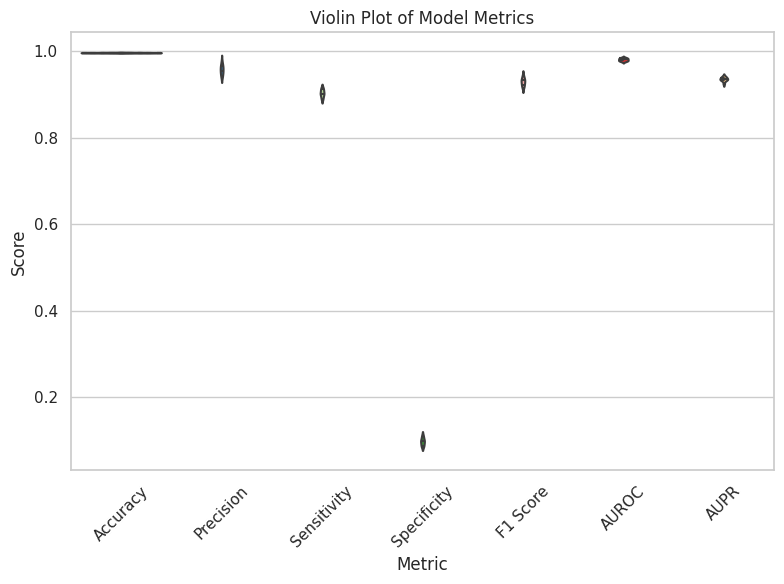

      Model       Metric     Score
0   Model 1     Accuracy  0.996970
1   Model 1    Precision  0.965116
2   Model 1  Sensitivity  0.902174
3   Model 1  Specificity  0.097826
4   Model 1     F1 Score  0.932584
..      ...          ...       ...
58  Model 9  Sensitivity  0.891304
59  Model 9  Specificity  0.108696
60  Model 9     F1 Score  0.921348
61  Model 9        AUROC  0.979224
62  Model 9         AUPR  0.941487

[63 rows x 3 columns]


In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import numpy as np

# Assuming models, x_test, and y_test are predefined.

metrics = {
    'Model': [],
    'Metric': [],
    'Score': []
}

# Store metrics for mean and std dev calculation
mean_std_metrics = {
    'Accuracy': [],
    'Precision': [],
    'Sensitivity': [],
    'Specificity': [],
    'F1 Score': [],
    'AUROC': [],
    'AUPR': []
}

for i, model in enumerate(models):
    y_pred_base = model.predict(x_test)
    
    accuracy = accuracy_score(y_test, y_pred_base)
    precision = precision_score(y_test, y_pred_base)
    sensitivity = recall_score(y_test, y_pred_base)  # Recall is sensitivity
    specificity = recall_score(y_test, 1 - y_pred_base)  # Specificity calculation
    f1 = f1_score(y_test, y_pred_base)
    auroc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    aupr = average_precision_score(y_test, model.predict_proba(x_test)[:, 1])

    # Append metrics to the dictionary in long format
    metrics['Model'].extend([f'Model {i+1}'] * 7)  # 7 metrics for each model
    metrics['Metric'].extend(['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score', 'AUROC', 'AUPR'])
    metrics['Score'].extend([accuracy, precision, sensitivity, specificity, f1, auroc, aupr])

    # Append to lists for mean and std dev calculation
    mean_std_metrics['Accuracy'].append(accuracy)
    mean_std_metrics['Precision'].append(precision)
    mean_std_metrics['Sensitivity'].append(sensitivity)
    mean_std_metrics['Specificity'].append(specificity)
    mean_std_metrics['F1 Score'].append(f1)
    mean_std_metrics['AUROC'].append(auroc)
    mean_std_metrics['AUPR'].append(aupr)

# Create a DataFrame in long format
metrics_df = pd.DataFrame(metrics)

# Compute mean and standard deviation for each metric
metric_stats = {metric: {"mean": np.mean(values), "std": np.std(values)} for metric, values in mean_std_metrics.items()}

# Print out mean and standard deviation for each metric
print("\nMean and Standard Deviation of Metrics:")
for metric, stats in metric_stats.items():
    print(f"{metric}: Mean = {stats['mean']:.4f}, Std Dev = {stats['std']:.4f}")

# Create a violin plot
plt.figure(figsize=(8, 6))
sns.set_theme(style='whitegrid')
sns.color_palette("Paired")
sns.violinplot(x='Metric', y='Score', data=metrics_df, inner='quartile',palette="Paired")
plt.title('Violin Plot of Model Metrics')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.xlabel('Metric')

# Annotating the plot with mean and std dev
for i, metric in enumerate(mean_std_metrics.keys()):
    mean_val = metric_stats[metric]['mean']
    std_val = metric_stats[metric]['std']
    # plt.text(i, mean_val, f'Mean: {mean_val:.4f}\nStd Dev: {std_val:.4f}', 
    #          horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.tight_layout()
plt.show()

# Displaying the metrics DataFrame
print(metrics_df)
